# DATASET DOWNLOAD


In [3]:
!pip install -q sentence_transformers
!pip install -q lxml


# Reading files

In [4]:
from pathlib import Path
from bs4 import BeautifulSoup

def html_to_text(path: Path, max_words=1500) -> dict:
    html = path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, "lxml")

    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()

    title = soup.title.get_text(" ", strip=True) if soup.title else path.stem
    text = soup.get_text(separator=" ", strip=True)

    text = " ".join(text.split()[:max_words])  # 🔥 TAGLIO

    return {"id": path.name, "title": title, "text": text}


files = list(Path(r"adm-2025-unsupervised-book-grouping\pages").glob("*.html"))
docs = [html_to_text(p) for p in files]
texts = [d["title"] + "\n" + d["text"] for d in docs]


In [17]:
import re

# patterns di rumore molto comuni
RE_URL = re.compile(r'https?://\S+|www\.\S+')
RE_EMAIL = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
RE_HTML_ENTITY = re.compile(r'&[a-zA-Z]+;|&#\d+;')
RE_NONWORD = re.compile(r"[^\w\sàèéìòùÀÈÉÌÒÙ'-]")  # tieni lettere accentate
RE_MULTISPACE = re.compile(r"\s+")
RE_LONG_NUM = re.compile(r"\b\d{5,}\b")  # numeri lunghi (id, hash, ecc.)
RE_FILE = re.compile(r"\b\w+\.(jpg|jpeg|png|gif|svg|pdf|epub|zip)\b", re.I)

# frasi boilerplate frequenti (personalizza se vuoi)
BOILERPLATE_PHRASES = [
    "cookie policy", "privacy policy", "terms of service", "all rights reserved",
    "copyright", "subscribe", "newsletter", "sign in", "log in"
]

def clean_for_transformer(text: str) -> str:
    t = text.lower()

    # rimuovi boilerplate frasi
    for p in BOILERPLATE_PHRASES:
        t = t.replace(p, " ")

    # rimuovi url/email/file e numeri lunghi
    t = RE_URL.sub(" ", t)
    t = RE_EMAIL.sub(" ", t)
    t = RE_FILE.sub(" ", t)
    t = RE_LONG_NUM.sub(" ", t)

    # pulizia caratteri/entità
    t = RE_HTML_ENTITY.sub(" ", t)
    t = RE_NONWORD.sub(" ", t)
    t = RE_MULTISPACE.sub(" ", t).strip()

    return t

def shorten_words(text: str, max_words=2500) -> str:
    return " ".join(text.split()[:max_words])

texts_clean = [shorten_words(clean_for_transformer(t), max_words=1500) for t in texts]


# Vectorizing by semantic

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
X = model.encode(texts_clean, normalize_embeddings=True, show_progress_bar=True)



Batches: 100%|██████████| 61/61 [00:42<00:00,  1.45it/s]


# Clustering

## elbow


c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

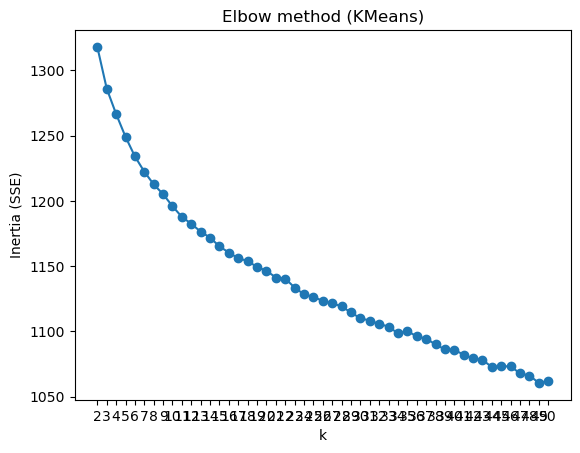

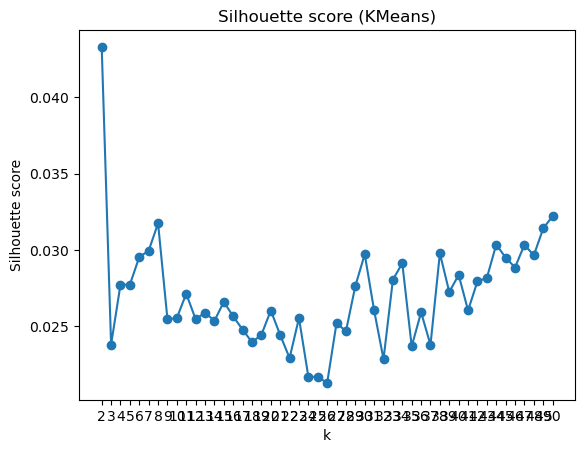

Best k (silhouette): 2


In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def kmeans_elbow_silhouette(
    X,
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None,  # es. 2000 se dataset enorme
):
    """
    Calcola inertia (elbow) e silhouette score per K in [k_min, k_max].
    Ritorna: ks, inertias, silhouettes
    """
    n_samples = X.shape[0]
    if n_samples < 3:
        raise ValueError("Servono almeno 3 campioni per usare silhouette in modo sensato.")

    k_max = min(k_max, n_samples - 1)
    ks = list(range(k_min, k_max + 1))

    inertias = []
    silhouettes = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)

        # silhouette richiede almeno 2 cluster e < n_samples
        # (qui k>=2 e k<=n_samples-1 già garantito)
        if sample_size_for_silhouette is not None and n_samples > sample_size_for_silhouette:
            sil = silhouette_score(X, labels, sample_size=sample_size_for_silhouette, random_state=random_state)
        else:
            sil = silhouette_score(X, labels)
        silhouettes.append(sil)

    return np.array(ks), np.array(inertias), np.array(silhouettes)


# --- USO ---
# X può essere:
# - embeddings: X_emb (shape: n_libri, 384) -> numpy array
# - TF-IDF: X_tfidf (shape: n_libri, n_features) -> sparse matrix

ks, inertias, sils = kmeans_elbow_silhouette(
    X,                 # <-- metti qui la tua matrice (X_emb o X_tfidf)
    k_min=2,
    k_max=50,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None  # oppure 2000 se hai dataset molto grande
)

# --- PLOT ELBOW ---
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans)")
plt.xticks(ks)
plt.show()

# --- PLOT SILHOUETTE ---
plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score (KMeans)")
plt.xticks(ks)
plt.show()

# --- k suggerito ---
best_k = int(ks[np.argmax(sils)])
print("Best k (silhouette):", best_k)

## autoencoder

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class AutoEncoder(nn.Module):
    def __init__(self, input_dim=384, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [7]:
X.shape

(1934, 384)

In [9]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = AutoEncoder(input_dim=X.shape[1], latent_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(150):
    total = 0
    for (x,) in loader:
        optimizer.zero_grad()
        x_hat = model(x)
        loss = loss_fn(x_hat, x)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch:02d} | loss={total/len(loader):.4f}")

Epoch 00 | loss=0.0023
Epoch 01 | loss=0.0019
Epoch 02 | loss=0.0018
Epoch 03 | loss=0.0017
Epoch 04 | loss=0.0016
Epoch 05 | loss=0.0015
Epoch 06 | loss=0.0014
Epoch 07 | loss=0.0014
Epoch 08 | loss=0.0013
Epoch 09 | loss=0.0013
Epoch 10 | loss=0.0013
Epoch 11 | loss=0.0013
Epoch 12 | loss=0.0012
Epoch 13 | loss=0.0012
Epoch 14 | loss=0.0012
Epoch 15 | loss=0.0012
Epoch 16 | loss=0.0012
Epoch 17 | loss=0.0011
Epoch 18 | loss=0.0011
Epoch 19 | loss=0.0011
Epoch 20 | loss=0.0011
Epoch 21 | loss=0.0011
Epoch 22 | loss=0.0011
Epoch 23 | loss=0.0011
Epoch 24 | loss=0.0011
Epoch 25 | loss=0.0011
Epoch 26 | loss=0.0010
Epoch 27 | loss=0.0010
Epoch 28 | loss=0.0010
Epoch 29 | loss=0.0010
Epoch 30 | loss=0.0010
Epoch 31 | loss=0.0010
Epoch 32 | loss=0.0010
Epoch 33 | loss=0.0010
Epoch 34 | loss=0.0010
Epoch 35 | loss=0.0010
Epoch 36 | loss=0.0010
Epoch 37 | loss=0.0010
Epoch 38 | loss=0.0010
Epoch 39 | loss=0.0010
Epoch 40 | loss=0.0010
Epoch 41 | loss=0.0010
Epoch 42 | loss=0.0009
Epoch 43 | 

In [10]:
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()


In [12]:
from sklearn.cluster import KMeans
k=8

labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Z)

c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


## classical methods

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state=42)
X_pca = pca.fit_transform(X)

print("Varianza cumulativa:", pca.explained_variance_ratio_.sum())


Varianza cumulativa: 0.8827363


In [23]:
X=X_pca

In [24]:
from sklearn.cluster import KMeans

k = 8
labels = KMeans(n_clusters=k, n_init="auto", random_state=42).fit_predict(X)


c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [33]:
from sklearn.mixture import GaussianMixture
k=8
gmm = GaussianMixture(
    n_components=k,
    covariance_type="full",   # più flessibile (default)
    n_init=5,
    random_state=42
)

labels = gmm.fit_predict(X)

c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\franc\anaconda3\envs\torch128\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

# Clusters

In [25]:
import numpy as np
from collections import defaultdict

# se hai usato TF-IDF: X è sparse, vectorizer esiste
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(texts)
feature_names = np.array(vectorizer.get_feature_names_out())

cluster_top_terms = {}
for c in sorted(set(labels)):
    idx = np.where(labels == c)[0]
    centroid = X_tfidf[idx].mean(axis=0)              # (1, n_features)
    top = np.asarray(centroid).ravel().argsort()[-10:][::-1]
    cluster_top_terms[c] = feature_names[top].tolist()

cluster_top_terms

{np.int32(0): ['he',
  'reacher',
  'his',
  'jack',
  'connelly',
  'series',
  'jack reacher',
  'michael connelly',
  'rebus',
  'lee child'],
 np.int32(1): ['vampire',
  'her',
  'she',
  'series',
  'anita',
  '2010',
  'vampires',
  'the vampire',
  'he',
  '2009'],
 np.int32(2): ['war',
  'his',
  'he',
  'vietnam',
  'world war',
  'the war',
  'hardcover',
  'and the',
  'american',
  'military'],
 np.int32(3): ['how',
  'life',
  'how to',
  'he',
  'his',
  'we',
  'habits',
  'power',
  'our',
  'the power'],
 np.int32(4): ['shakespeare',
  'her',
  'she',
  'his',
  'he',
  'king',
  'series',
  'plays',
  'me',
  'of shakespeare'],
 np.int32(5): ['her',
  'she',
  'christie',
  'poirot',
  'agatha',
  'series',
  'agatha christie',
  'ilona',
  'he',
  'his'],
 np.int32(6): ['her',
  'she',
  'series',
  'dark',
  'he',
  'his',
  'night',
  'hunter',
  '2011',
  '2010'],
 np.int32(7): ['her',
  'she',
  'he',
  'me',
  'love',
  'his',
  'just',
  '2013',
  'they',
  'se

In [35]:
!pip install -q pandas

In [26]:
import pandas as pd

rows = []
for i, d in enumerate(docs):
    rows.append({
        "ID": i,
        "TARGET": int(labels[i])
    })

df = pd.DataFrame(rows)
df.to_csv("book_clusters.csv", index=False, encoding="utf-8")

df.head()

,ID,TARGET
0,0,5
1,1,1
2,2,3
3,3,7
4,4,3
